# Latent Dirichlet Allocation
---
  
**LDA**  
- Generative Probabilistic Topic Model. 
- Assumes documents are a mixture of topics and that each word in the document is attributable to a topic  
- The topic probabilities provide an explicit representation of a document

## Env Preparation

In [1]:
import os
import sys
# os.chdir('/Users/pabloruizruiz/OneDrive/Courses/NLP_Stanford/Complementary_Courses/Document_Clustering')
os.chdir('/home/jovyan/work/')
print('Workdir: ', os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

Workdir:  /home/jovyan/work


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

FileNotFoundError: [Errno 2] No such file or directory: 'config.yaml'

## Data Preparation

In [4]:
data = pd.read_csv(JP('data','bbc-text.csv'))
data['lenght'] = data.text.apply(lambda l: len(l.split(' ')))
data.head()

,category,text,lenght
0,tech,tv future in the hands of viewers with home th...,806
1,business,worldcom boss left books alone former worldc...,332
2,sport,tigers wary of farrell gamble leicester say ...,270
3,sport,yeading face newcastle in fa cup premiership s...,390
4,entertainment,ocean s twelve raids box office ocean s twelve...,287


In [5]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm') # Powerfull model with everytihing included

def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

In [10]:
data['processed'] = data['text'].progress_apply(nlp).progress_apply(spacy_cleaning)
data.to_csv(JP('data','bbc-text-processed.csv'))

100%|██████████| 2225/2225 [00:02<00:00, 1042.53it/s]


In [6]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


In [7]:
print('\nBefore Processing')
doc_list = [d for d in data.text]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

print('\nAfter Processing')
doc_list = [d for d in data.processed]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))


Before Processing
Total documents:  2225
All words: 933960. Unique words: 43772

After Processing
Total documents:  2225
All words: 339642. Unique words: 15191


## TFIDF

In [36]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
EMBED_SIZE = 10000 
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print(NUM_CLUSTERS)

5


In [38]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [39]:
catalog = Catalog()
catalog.documents = documents

In [64]:
vectorizer = TfidfVectorizer(
    min_df=.05,
    max_df=.8,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

In [65]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(2225, 460)


,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.094,0.316,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Sklearn Topic Modelling

- 1: Latent Dirichlet Allocation
- 2: Non Negative Matrix Factorization

In [42]:
NUM_TOPICS = NUM_CLUSTERS

In [43]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]]) 

### Latente Dirichlet Allocation

In [44]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
lda = LatentDirichletAllocation(
    n_components=NUM_TOPICS, 
    max_iter=10, 
    learning_method='online',
    verbose=True)
lda


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=True)

In [21]:
print('Latent Semantion Allocation')
data_lda = lda.fit_transform(tfidf.representation)

Latent Semantion Allocation
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [22]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer, 8)

LDA Model:
Topic 0:
['child', 'budget', 'cost', 'party', 'firm', 'network', 'share', 'dollar']
Topic 1:
['card', 'age', 'beat', 'party', 'common', 'year', 'win', 'play']
Topic 2:
['firm', 'company', 'year', 'sale', 'market', 'share', 'people', 'technology']
Topic 3:
['government', 'election', 'party', 'labour', 'plan', 'people', 'tory', 'law']
Topic 4:
['win', 'film', 'game', 'play', 'award', 'player', 'year', 'star']


**Save Model**

In [26]:
with open(JP(paths['checkpoints'], 'lda_sklearn.pkl'), 'wb') as obj:
    pickle.dump(lda,obj)

**Load Model**

In [45]:
with open(JP(paths['checkpoints'], 'lda_sklearn.pkl'), 'rb') as obj:
    lda = pickle.load(obj)
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=True)

#### Visualization

In [59]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [68]:
pyLDAvis.sklearn.prepare(lda, tfidf.representation, tfidf.mapping, mds='tsne')

AttributeError: 'Series' object has no attribute 'getA1'

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=10000,
                min_df=0.05, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

## Non-Negative Matrix Factorization

In [18]:
nmf = NMF(n_components=NUM_TOPICS)
nmf

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [28]:
print('Non-Negative Matrix Factorization')
data_nmf = nmf.fit_transform(tfidf.representation)

Non-Negative Matrix Factorization


In [29]:
# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model:")
selected_topics(nmf, vectorizer, 8)

NMF Model:
Topic 0:
['sale', 'year', 'rise', 'company', 'market', 'growth', 'share', 'price']
Topic 1:
['game', 'win', 'play', 'player', 'match', 'team', 'final', 'injury']
Topic 2:
['film', 'award', 'star', 'win', 'movie', 'include', 'director', 'year']
Topic 3:
['election', 'party', 'labour', 'government', 'tory', 'plan', 'tax', 'leader']
Topic 4:
['people', 'mobile', 'phone', 'technology', 'user', 'music', 'service', 'computer']


**Save Model**

In [30]:
with open(JP(paths['checkpoints'], 'NNMF.pkl'), 'wb') as obj:
    pickle.dump(nmf,obj)

**Load Model**

In [20]:
with open(JP(paths['checkpoints'], 'NNMF.pkl'), 'rb') as obj:
    nmf = pickle.load(obj)
nmf

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

## Gensin

In [70]:
from gensim import corpora, models, similarities 

In [71]:
NUM_TOPICS = 5

In [72]:
data['processed_token'] = data['processed'].apply(lambda t: t.split())
data['processed_token']

0       [tv, future, hand, viewer, system, plasma, hig...
1       [left, book, ebber, accuse, oversee, 11bn, fra...
2       [wary, farrell, gamble, rush, make, bid, decid...
3       [yeade, face, premiership, face, trip, leader,...
4       [raid, ocean, crime, go, number, office, chart...
                              ...                        
2220    [car, pull, retail, figure, retail, sale, fall...
2221    [unveil, ex, chatshow, host, attack, policy, i...
2222    [concert, band, announce, plan, perform, scott...
2223    [political, squabble, snowball, s, commonplace...
2224    [delight, souness, feel, danger, go, early, go...
Name: processed_token, Length: 2225, dtype: object

In [73]:
# Create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(data['processed_token']) 
dictionary.filter_extremes(no_below=0.1, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in data['processed_token']]

In [37]:
import time
start = time.time()
ldaModel = models.LdaModel(
    corpus, 
    num_topics=NUM_TOPICS,
    id2word=dictionary, 
    update_every=5, 
    chunksize=1000, 
    passes=300)
print('It took me {}'.format(time.time()-start))

It took me 525.1944804191589


In [41]:
import time
start = time.time()
ldaModelMulticore = models.LdaMulticore(
    corpus, 
    num_topics=NUM_TOPICS,
    id2word=dictionary, 
    chunksize=1000, 
    passes=300)
print('It took me {}'.format(time.time()-start))

It took me 317.51400566101074


**Save Model**

In [40]:
with open(JP(paths['checkpoints'], 'lda_gensim.pkl'), 'wb') as obj:
    pickle.dump(ldaModel,obj)
    
with open(JP(paths['checkpoints'], 'lda_multicore_gensim.pkl'), 'wb') as obj:
    pickle.dump(ldaModelMulticore,obj)

**Load Model**

In [76]:
with open(JP(paths['checkpoints'], 'lda_gensim.pkl'), 'rb') as obj:
    ldaModel = pickle.load(obj)
    
# with open(JP(paths['checkpoints'], 'lda_multicore_gensim.pkl'), 'rb') as obj:
#     ldaModelMulticore = pickle.load(obj)
    
print(ldaModel)
# print(ldaModelMulticore)

LdaModel(num_terms=15190, num_topics=5, decay=0.5, chunksize=1000)


### Aggregate Results into Pandas

In [79]:
ldaModel.show_topics(formatted=False, num_words=2)

[(0, [('people', 0.012326101), ('technology', 0.00792511)]),
 (1, [('film', 0.016962005), ('year', 0.010820281)]),
 (2, [('year', 0.016191844), ('company', 0.010608404)]),
 (3, [('game', 0.014529131), ('win', 0.01390133)]),
 (4, [('government', 0.013069983), ('election', 0.009872554)])]

In [80]:
from functools import reduce

scores = []
for c in range(NUM_TOPICS):
    df = pd.DataFrame(ldaModel.show_topic(c,topn=None), columns=['word',c+1])
    scores.append(df)
    
scores = reduce(lambda df1, df2: df1.merge(df2, on='word'), scores)
scores.head(3)

,word,1,2,3,4,5
0,people,0.012,0.004,0.001,0.001,0.009
1,technology,0.008,0.000,0.000,0.000,0.000
2,mobile,0.008,0.000,0.000,0.000,0.000


#### Visualization

In [81]:
import pyLDAvis.gensim as gensimvis

In [83]:
vis_data = gensimvis.prepare(ldaModel, corpus, dictionary)


---

# Plotting the WordClouds


In [85]:
%matplotlib inline
from wordcloud import WordCloud

#### Helper Functions for Plotting

In [86]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    print(n_rows,n_cols)
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)


In [87]:
def cluster_to_wordcloud(
    df, max_words=200, use_mask=False, bgcolor='black'):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color=bgcolor).generate_from_frequencies(
            frequencies=dict(zip(df.word, df.score)))
    return wordcloud


In [88]:
def plot_centroids_as_wordclouds(
    word_scores,
    NUM_CLUSTERS = None,
    max_words_per_cloud=100, 
    use_mask=False, n_cols=2, figsize=(15,15)):

    if not NUM_CLUSTERS:
        NUM_CLUSTERS = word_scores.cluster.nunique()

    n_plots = NUM_CLUSTERS
    _, axs = define_subplots(n_cols,n_plots, figsize)
    
    for c in range(NUM_CLUSTERS):
        wordcloud = cluster_to_wordcloud(
            df=word_scores[word_scores.cluster == c+1],
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return


In [89]:
data = pd.melt(scores.set_index('word').T.rename_axis('cluster').reset_index(), 
               id_vars=['cluster'], var_name='word', value_name='score')
data.head()

,cluster,word,score
0,1,win,0.014
1,2,win,0.001
2,3,win,0.000
3,4,win,0.009
4,5,win,0.002


3 2


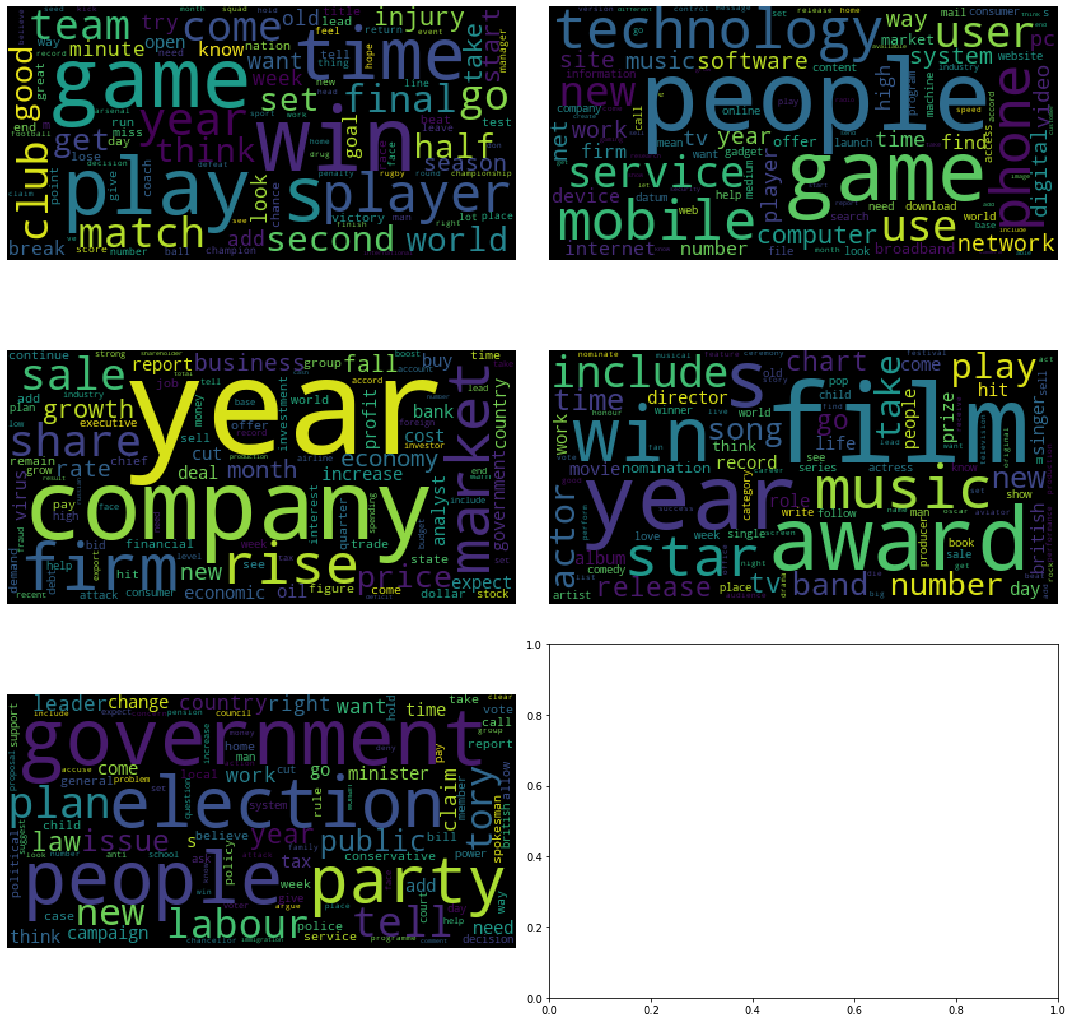

In [90]:
plot_centroids_as_wordclouds(data, n_cols=2)

# Validation

**According to importants words of cluster lets assigned a classification:**

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [92]:
cluster_preds = ['sport', 'entertainment', 'business', 'tech', 'politics']  
d = dict(zip(range(NUM_CLUSTERS), cluster_preds))
d

{0: 'sport', 1: 'entertainment', 2: 'business', 3: 'tech', 4: 'politics'}

In [93]:
data['predict'] = [d[i] for i in clusters.labels_]

NameError: name 'clusters' is not defined

In [ ]:
print(data.category.value_counts())

In [ ]:
print(data.predict.value_counts())

In [ ]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.predict, 
    labels=cluster_preds)

pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)